# Churn customers

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

file = "churn.csv"

## Helpers

In [2]:
def annot_max(x,y, ax=None):
    # auto annotate the max point of a fig given its x and y
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.0f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

# df_Class

In [33]:
class df_class:
    
    def __init__(self,csv_file_name, label='churn', index_col=None):   #can receive a different label column   
        self.name = os.path.splitext(csv_file_name)[0]
        self.df = pd.read_csv(csv_file_name ,index_col=index_col) \
            .rename(columns=str.lower) \
            .replace(to_replace = ['Yes','No','No phone service','No internet service'],value = [1,0,0,0])
        self.label = label
        try:
            self.df["totalcharges"] = pd.to_numeric(self.df["totalcharges"].replace(" ", 0))
            self.df['years']=self.df['tenure']//12
        except Exception as e:
            print(f'error: {e}')
        
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name
    
    def describe_df(self):
        # df shape
        print(f'The DataFrame has {self.df.shape[0]} rows and {self.df.shape[1]} columns (including index, label and calculated columns)')
        print('')
        
        # percent of label == True
        pct_label = dfc.df[dfc.label].sum()/dfc.df[dfc.label].count()*100
        print(f'Percent of {dfc.label}: {pct_label} %')
        print('')
        
        # calculate the number of unique values for each column
        print('Value counts per column in the df:')
        print(self.df.nunique())
    
    def prepare_for_model(self):
        if self.df.isna().sum().sum() == 0:
            print('The data contains no nulls, ready for models')
            self.df_for_model = pd.get_dummies(self.df)
        else:
            print('Data contains nulls:')
            self.correct_nulls()
    
    def correct_nulls(self):
        # get the sum of missing values for each column
        na_sum = self.df.isna().sum()
        print(na_sum.loc[na_sum > 0])

        # get the list of columns with missing values
        cols_with_na = na_sum.loc[na_sum > 0].index.tolist()
        for col in cols_with_na:
            replacement_value = input(f'Enter value to replace nulls in the column {col} (default=0): ')
            if replacement_value == np.nan: # pressing enter deaults to zero
                replacement_value=0                                     
            self.df[col].fillna(replacement_value, inplace=True)
        self.prepare_for_model()
 
    def histplot(self,column='years'):      
        label = self.label
        cross_tab_prop=pd.crosstab(index=self.df[column],columns=self.df[label],normalize='index')
        cross_tab=pd.crosstab(index=self.df[column],columns=self.df[label])
        cross_tab_prop.plot(kind='bar', 
                        stacked=True, 
                        colormap='tab10', 
                        figsize=(10, 6),
                        fontsize=14)

        plt.legend(loc="lower right", labels = ['{}: False'.format(label),'{}: True'.format(label)], fontsize=12)
        plt.xlabel(column,fontsize=14)
        plt.ylabel("Proportion",fontsize=14)
        plt.title('%{} over {}'.format(label, column),fontsize=16)

        for n, x in enumerate([*cross_tab.index.values]):
            for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                                  cross_tab.loc[x],
                                                  cross_tab_prop.loc[x].cumsum()):

                plt.text(x=n - 0.0,
                         y=(y_loc - proportion) + (proportion / 2),
                         s=f'{count}\n{np.round(proportion * 100, 0).astype(int)}%', 
                         color="black",
                         horizontalalignment='center',
                         fontsize=12
                         )
        plt.show()

    def percent_label_by_column(self, col):
        label = self.label
        df = dfc.df.copy()
        df['label_perc'] = df.groupby(col)[label].transform(lambda x: x.sum() / len(x))

        # Create a line plot of churn percentage per tenure
        plt.figure(figsize=(15, 6))
        ax = sns.lineplot(data=df, x=col, y='label_perc')
        for x, y in zip(df[col], df['label_perc']):
            ax.annotate(f'{x}', xy=(x, y), textcoords='offset points', xytext=(0, 10), ha='center')
        plt.title(f'{label} Percentage by {col}')

        # Show the plot
        plt.show()
        
    def features_correlation_to_label(self):
        label = self.label
        if hasattr(self, 'df_for_model'):
            df = self.df_for_model
            fig = df.corr()[label].drop(label).sort_values().plot(kind='barh')
            plt.show()
        else:
            print('Please run "prepare_for_model()" before running this')   
    
    def corr(self):
        label = self.label
        if hasattr(self, 'df_for_model'):
            corr = self.df_for_model.corr()
            plt.figure(figsize=(12, 8))
            sns.heatmap(corr, annot=False, cmap='coolwarm', annot_kws={"fontsize":14}, cbar=False, 
                        linewidths=0.5, square=True)
            plt.show()
        else:
            print('Please run "prepare_for_model()" before running this')
        
    def train_test(self):
        from sklearn.model_selection import train_test_split
        label = self.label
        if hasattr(self, 'df_for_model'):
            df = self.df_for_model
            train, test = train_test_split(df, test_size=0.2, random_state=0, shuffle=True)
            x_train = train.drop(label, axis=1)
            y_train = train[label]
            x_test, y_test = test.drop(label, axis=1), test[label]
            return (x_train, y_train, x_test, y_test)
        else:
            print('Please run "prepare_for_model()" before running this')   

    def accuracy_score(self, y_test, y_test_pred):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y_test, y_test_pred)
    
    def decision_tree(self, max_depth=5, draw=False):
        from sklearn.tree import DecisionTreeClassifier # Importing the algorithm        
        label = self.label
        (x_train, y_train, x_test, y_test) = self.train_test()

        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(x_train, y_train) # running\training the algorithm with the train data
        y_test_pred_DecisionTree = clf.predict(x_test) # making a prediction based on "test" data features

        if draw:
            from sklearn.tree import DecisionTreeClassifier, export_graphviz
            from IPython.display import SVG
            from graphviz import Source
            from IPython.display import display

            # this is a function that we can always use for plotting decision trees, the function expects 3 arg as follows
            def plot_tree(tree, features, labels):
                graph = Source(export_graphviz(tree, feature_names=features, class_names=labels, filled = True))
                display(SVG(graph.pipe(format='svg')))
            
            plot_tree(clf, x_train.columns, ['{}: False'.format(label), '{}: True'.format(label)])
            

        accuracy_score = self.accuracy_score(y_test, y_test_pred_DecisionTree)
        return accuracy_score
    
    def knn(self, n_neighbors=121):
        from sklearn.neighbors import KNeighborsClassifier  # Importing the algorithm
        from sklearn.preprocessing import StandardScaler # import the libraries
        
        import warnings # todo: 
        warnings.simplefilter("ignore", FutureWarning)

        scaler = StandardScaler() # define
        (x_train, y_train, x_test, y_test) = self.train_test()
        x_train_scaled = scaler.fit_transform(x_train) # Fit to data, then transform it.
        x_test_scaled = scaler.transform(x_test) # Perform standardization by centering and scaling

        
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        clf.fit(x_train_scaled, y_train)

        y_test_pred_Knn_Scaled = clf.predict(x_test_scaled)

        accuracy_score = self.accuracy_score(y_test, y_test_pred_Knn_Scaled)
        
        return accuracy_score

    def random_forest(self, n_estimators=11, max_depth=10):
        from sklearn.ensemble import RandomForestClassifier # Importing the algorithm
        label = self.label
        (x_train, y_train, x_test, y_test) = self.train_test()
        
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=1)
        model.fit(x_train, y_train) # running\training the algorithm with the train data
        y_test_pred_RandomForest = model.predict(x_test) # making a prediction based on "test" data features
        
        self.rf_model = model
        accuracy_score = self.accuracy_score(y_test, y_test_pred_RandomForest)
        
        return accuracy_score
    
    def feature_importances(self, draw=False):
        if hasattr(self, 'rf_model'):
            model = self.rf_model
            feature_importances = model.feature_importances_
            features = model.feature_names_in_ # all the features
            stats = pd.DataFrame({'feature':features, 'importance':feature_importances}).sort_values('importance', ascending=False)  # creating the data frame
            
            if draw:
                stats.plot(y='importance', x='feature', kind='barh')
                plt.title('Feature Importance of Random Forest'); 

            return stats
        else:
            print('No Random forest model found. Please run random_forest() first')
    
    def compare_decision_tree_depths(self, depths=range(3,12), draw=False):
        accuracies = np.array([self.decision_tree(i) for i in depths])
        if draw:
            fig = sns.lineplot(x=depths, y = accuracies).set(title='Accuracy of model over tree depth', xlabel='Tree depth', ylabel='Accuracy')
            annot_max(depths,accuracies)

        best_accuracy = np.amax(accuracies)
        best_depth    = depths[np.argmax(accuracies)]      

        return (best_accuracy, best_depth)
    
    def compare_random_forest(self, estimators_list=range(1,101,5), depths=[5,10,15], draw=False):
        results = []
        for n in estimators_list:
            for d in depths:
                accuracy = self.random_forest(n_estimators=n, max_depth=d)
                results.append((n, d, accuracy))
        df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'accuracy'])

        if draw:
            sns.lineplot(x='n_estimators', y='accuracy', hue='max_depth', data=df).set(title='Random Forest Accuracy over n_estimators and depths')
            annot_max(df['n_estimators'],df['accuracy'])
        
        id_max = df.accuracy.idxmax()

        best_accuracy =     df.loc[id_max,'accuracy']
        best_n_estimators = df.loc[id_max,'n_estimators']
        best_max_depth =    df.loc[id_max,'max_depth']
        
        return (best_accuracy, best_n_estimators, best_max_depth)
    
    def compare_knn(self, neighbours=[5, 10, 20, 40], draw=False):
        accuracies = np.array([self.knn(i) for i in neighbours])
        if draw:
            fig = sns.lineplot(x=neighbours, y=accuracies).set(title='Accuracy over n neighbours', xlabel='Neighbours', ylabel='Accuracy')
            annot_max(neighbours, accuracies)
            
        best_accuracy = np.amax(accuracies),
        best_neighbours    = neighbours[np.argmax(accuracies)]
        
        return (best_accuracy, best_neighbours)
    
    def compare_methods(self, d_depth=5, n_estimators=11, rf_depth=10, neighbours=121):        
        accs = {}
        accs['Decision tree'] = self.decision_tree(max_depth=d_depth, draw=False)
        accs['Random forest'] = self.random_forest(max_depth=rf_depth, n_estimators=n_estimators)
        accs['KNN']           = self.knn(n_neighbors=neighbours)
        accs['Benchmark']     = self.get_benchmark_accuracy()
      
        max_len = max(len(key) for key in accs.keys())

        # print keys and values with values aligned
        for key, value in accs.items():
            print('{:{}} {}'.format(key, max_len, value))
    
        return accs
    
    def add_columns_counter(self, columns_list: list):
        """
        Takes a list of columns from the df and sums them in a new column 'columns_counter'      
        """
        self.df['columns_counter'] = self.df[columns_list].sum(axis=1, numeric_only=True)
        show = columns_list + ['columns_counter']
        
        return self.df.loc[:,show]
    
    def get_benchmark_accuracy(self):
        label = self.label
        (x_train, y_train, x_test, y_test) = self.train_test()
        # The benchmark would be the most common label in the train set
        benchmark_value = y_train.value_counts().idxmax() # zero
        y_test_pred_Benchmark = np.ones(len(x_test))*benchmark_value
        benchmark_acc = self.accuracy_score(y_test, y_test_pred_Benchmark)

        return  benchmark_acc  
    
    def predict_label(self, x):
        """ Returns the top x indices who have label=False but are at the highest risk to have label=True """
        label = self.label
        if hasattr(self, 'df_for_model'):           
            # Using the trained random forest model to predict the probability of churn for each customer who hasn't churned
            if hasattr(self, 'rf_model'):
                df = self.df_for_model.copy()
                df_for_proba = df[df[label]==0] # Leave only label=False rows
                df_for_proba = df_for_proba.drop(columns=[label])

                probability_to_churn = self.rf_model.predict_proba(df_for_proba)
                df_for_proba['label_probability'] = probability_to_churn[:, 1] #The 1 column refers to label=True
                # Print the resulting DataFrame
                top_x_risk_to_churn = df_for_proba['label_probability'].sort_values(ascending=False).head(x)
            
                return top_x_risk_to_churn
            else:
                print('No Random forest model found. Please run random_forest() first')
        else:
            print('Please run "prepare_for_model()" before running this')  
            
        
        
dfc = df_class(file, index_col='customerID', label = 'churn')


# EDA

## Dataset shape and label distribution

In [7]:
dfc.describe_df()

The DataFrame has 7043 rows and 21 columns (including index, label and calculated columns)

Percent of churn: 26.536987079369588 %

Value counts per column in the df:
gender                 2
seniorcitizen          2
partner                2
dependents             2
tenure                73
phoneservice           2
multiplelines          2
internetservice        3
onlinesecurity         2
onlinebackup           2
deviceprotection       2
techsupport            2
streamingtv            2
streamingmovies        2
contract               3
paperlessbilling       2
paymentmethod          4
monthlycharges      1585
totalcharges        6531
churn                  2
years                  7
dtype: int64


## Histograms

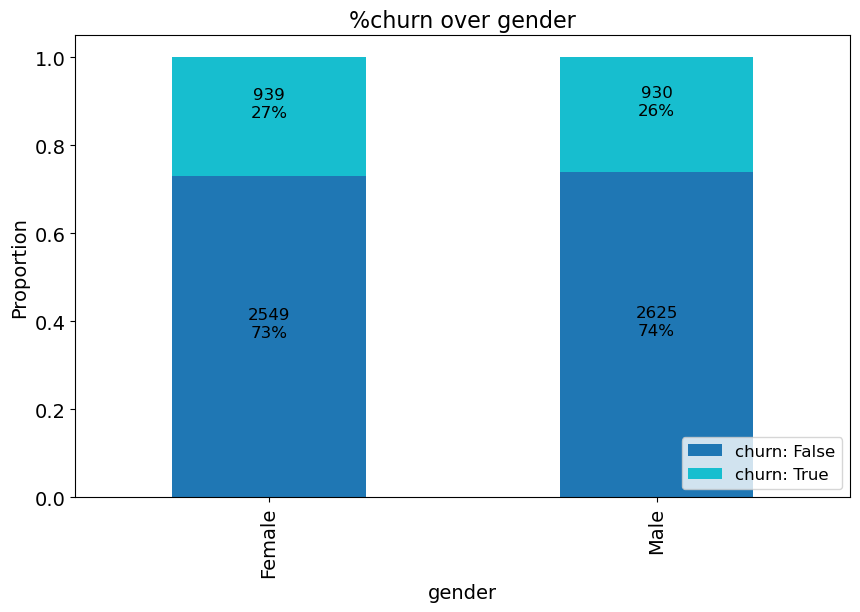

In [8]:
# The same function above works with different columns
dfc.histplot('gender')

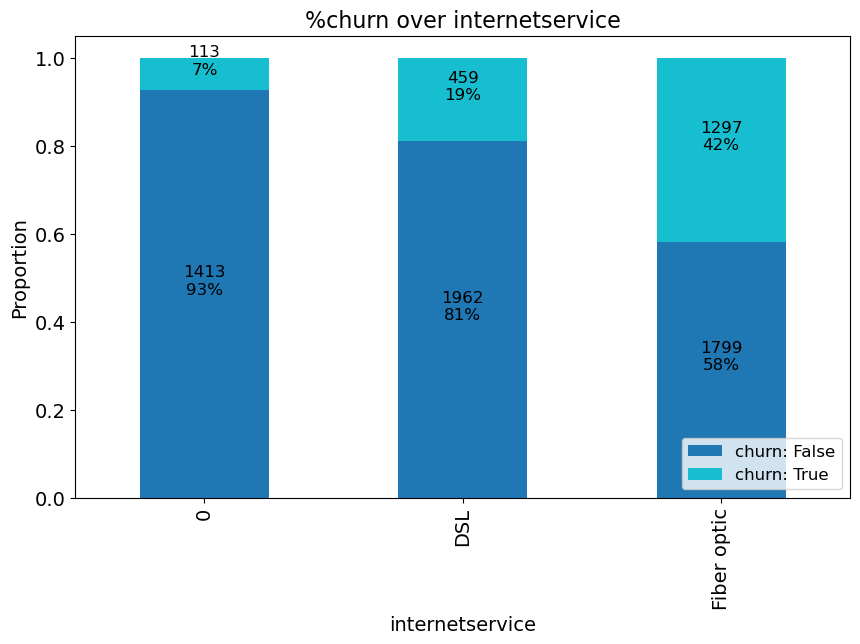

In [9]:
dfc.histplot('internetservice')

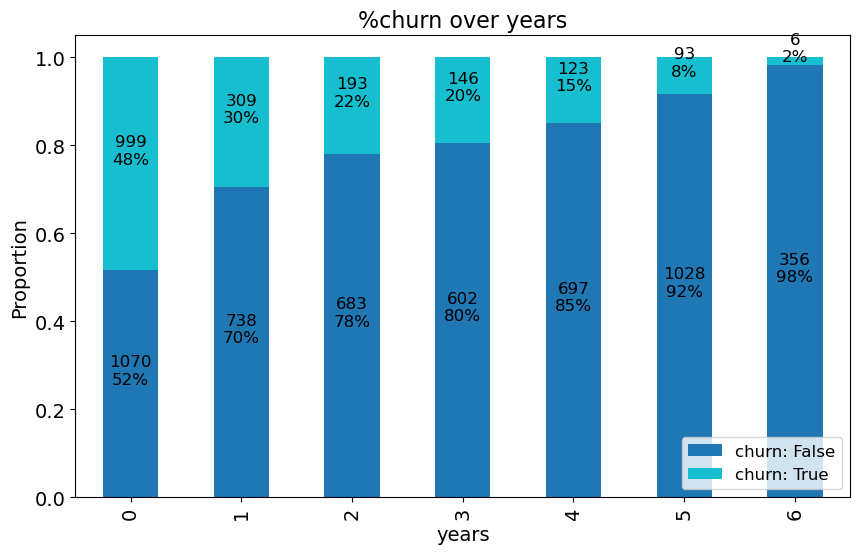

In [10]:
dfc.histplot('years')
# The more years a customer stays with us, the less chance for him to churn. 
# Prone to churn especially in the first year.

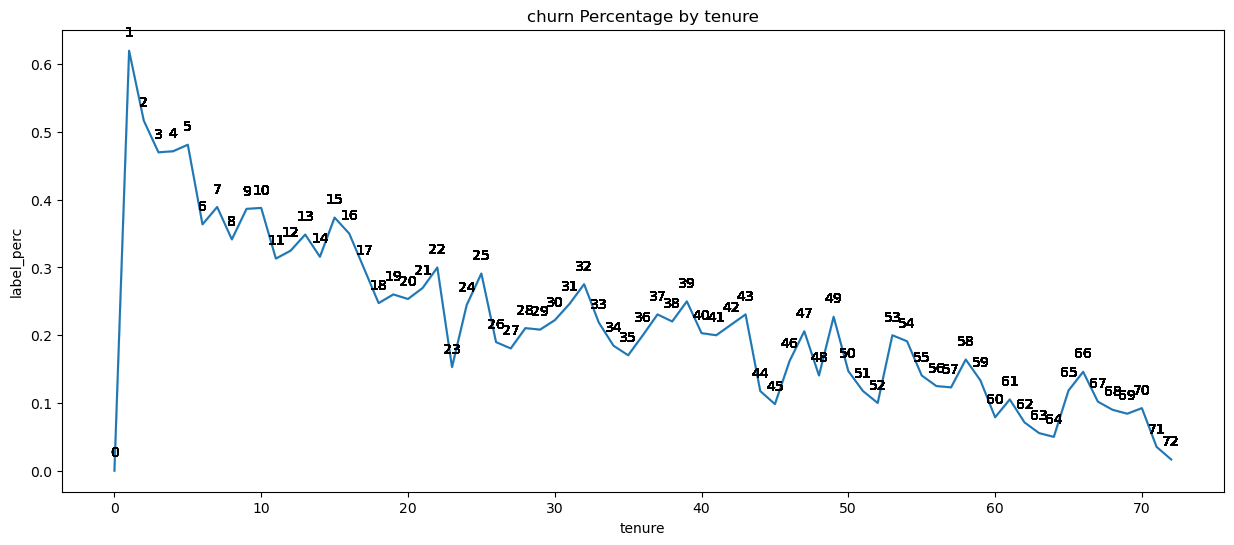

In [11]:
# We wanted to see if there is some cyclic affect like more customers churn at certain months
# Optional: takes a long time to plot

# dfc.percent_label_by_column('tenure')

## Check df before models

In [34]:
# Optional - insert nulls and you'll be asked to replace them with a value
# dfc.df.loc['7590-VHVEG','tenure']=np.nan
# dfc.df.loc['7590-VHVEG','years']=np.nan

dfc.prepare_for_model()

The data contains no nulls, ready for models


## Features affecting the label

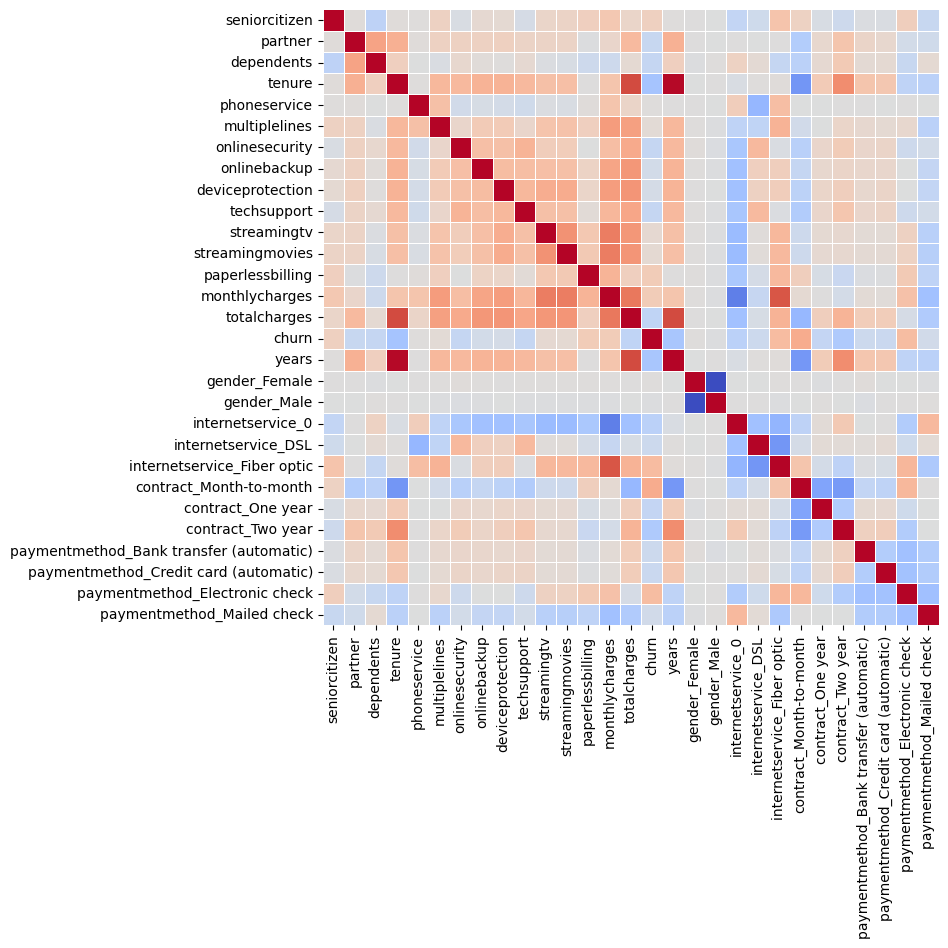

In [10]:
dfc.corr()


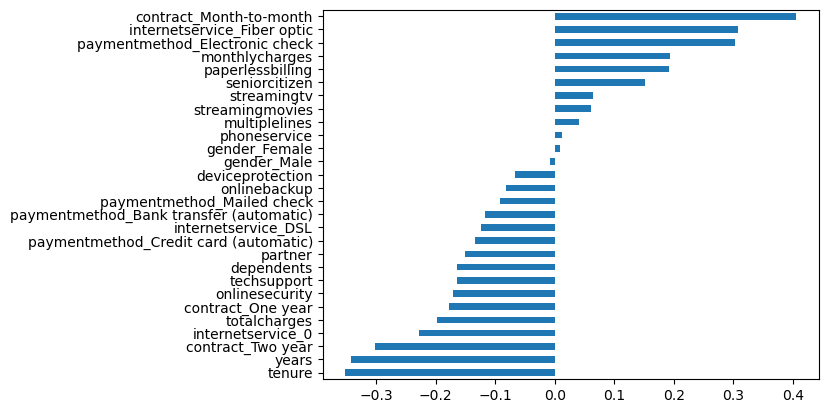

In [11]:
dfc.features_correlation_to_label()

# Calculated features

## count paid services?

In [12]:
# Count several columns (products) together so they can be removed

# list_of_columns_to_count = ['phoneservice', 'multiplelines', 'onlinesecurity',
#        'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
#        'streamingmovies']
# dfc.add_columns_counter(list_of_columns_to_count)


In [13]:
# dfc.df = dfc.df.drop(columns=list_of_columns_to_count)

# This feature decreased the accuracy so we dropped it in this case

## Remove uncontributing features?

                                    feature  importance
3                                    tenure    0.161559
13                           monthlycharges    0.133248
14                             totalcharges    0.124433
21                  contract_Month-to-month    0.121361
20              internetservice_Fiber optic    0.071144
15                                    years    0.065247
26           paymentmethod_Electronic check    0.042392
12                         paperlessbilling    0.021086
6                            onlinesecurity    0.021038
19                      internetservice_DSL    0.020403
5                             multiplelines    0.017467
2                                dependents    0.017070
9                               techsupport    0.016196
23                        contract_Two year    0.016192
7                              onlinebackup    0.015460
10                              streamingtv    0.014817
22                        contract_One year    0

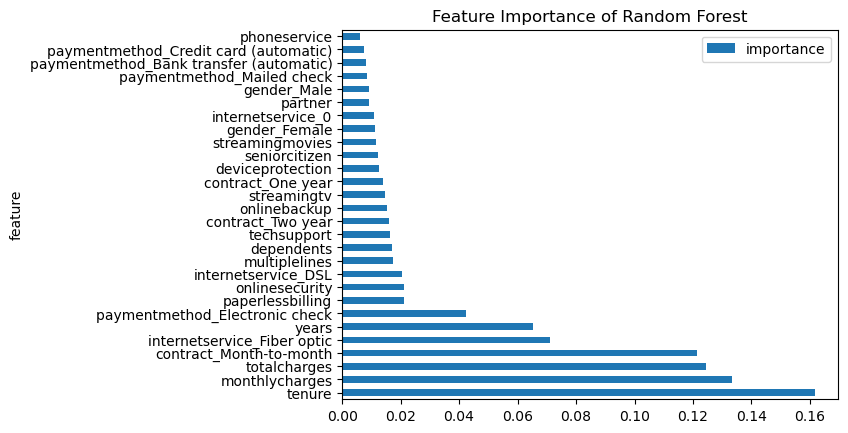

In [9]:
# Model with Random forest with default parameters to get feature_importance
# dfc.prepare_for_model()
# dfc.random_forest()
stats = dfc.feature_importances(draw=True)
print(stats)

In [18]:
# List of features we can drop
features_to_drop = ['phoneservice', 'paymentmethod_Credit card (automatic)', 'paymentmethod_Bank transfer (automatic)', 'paymentmethod_Mailed check','gender_Male', 'gender_Female', 'streamingmovies']

dfc.df_for_model = dfc.df_for_model.drop(columns=features_to_drop, axis=1)


# ML models

## Decision tree

The optimal tree depth is 5 with an accuracy of 0.7842441447835344


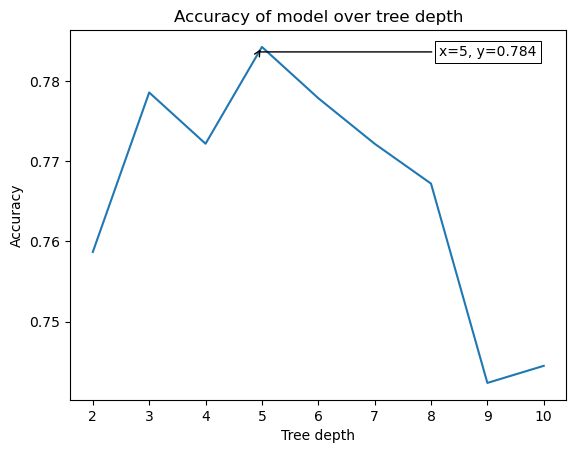

In [35]:
# Get the best parameters for a decision tree:
d_best_acc, d_best_depth = dfc.compare_decision_tree_depths(range(2,11), draw=True)
print(f"The optimal tree depth is {str(d_best_depth)} with an accuracy of {str(d_best_acc)}")

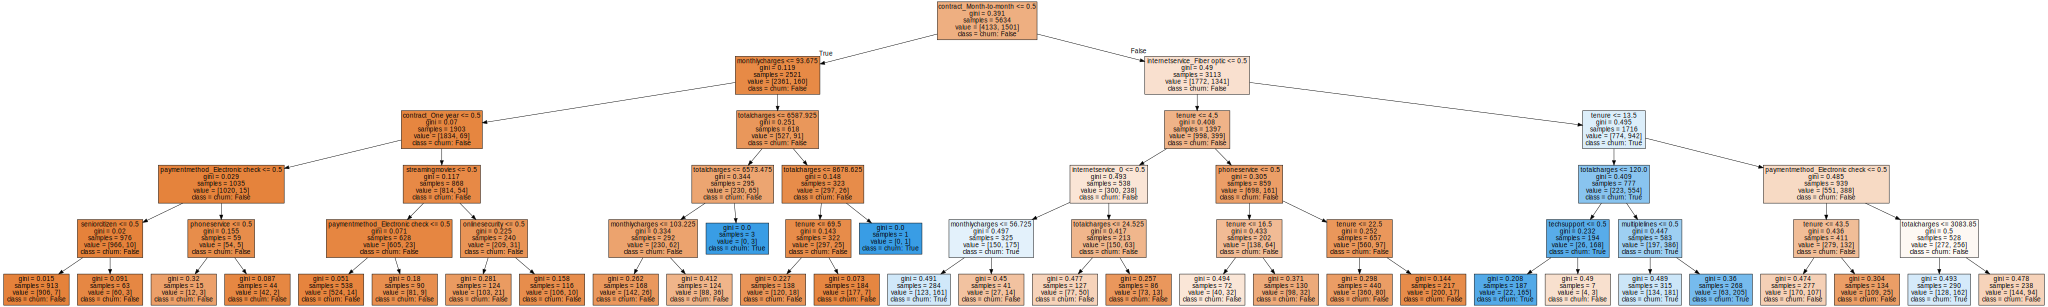

0.7842441447835344

In [36]:
# Run and draw decision tree with the best parameters
dfc.decision_tree(max_depth=d_best_depth, draw=True)

## Random forest


        The optimal parameters for Random Forest are
        n_estimators = 11
        max_depth = 5
        with an accuracy of 0.7977288857345636
        


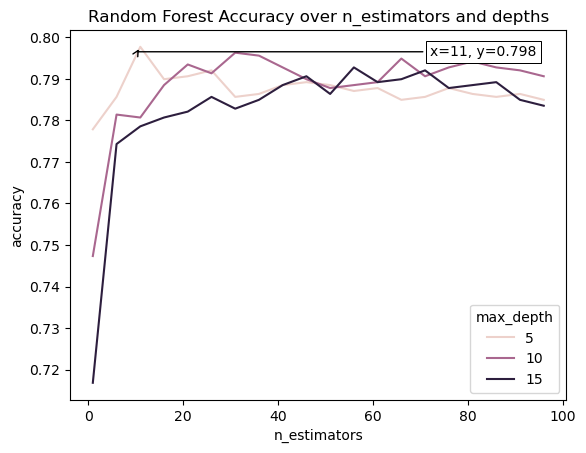

In [37]:
# Find best parameters to run Random Forest in:
(rf_best_accuracy, rf_best_n_estimators, rf_best_max_depth) = dfc.compare_random_forest(estimators_list=range(1,101,5), depths=[5, 10, 15], draw=True)
print(f"""
        The optimal parameters for Random Forest are
        n_estimators = {rf_best_n_estimators}
        max_depth = {rf_best_max_depth}
        with an accuracy of {rf_best_accuracy}
        """)

In [38]:
# Run Random forest with the optimal parameters
# rf_best_n_estimators, rf_best_max_depth = 11, 5 # if don't want to recalculate
acc = dfc.random_forest(n_estimators=rf_best_n_estimators, max_depth=rf_best_max_depth)
print(f"The optimal tree max_depth is {str(rf_best_max_depth)} and {str(rf_best_n_estimators)} estimators with an accuracy of {str(acc)}")

The optimal tree max_depth is 5 and 11 estimators with an accuracy of 0.7977288857345636


,feature,importance
3,tenure,0.184033
21,contract_Month-to-month,0.168882
15,years,0.136667
20,internetservice_Fiber optic,0.124548
26,paymentmethod_Electronic check,0.078102
14,totalcharges,0.065120
13,monthlycharges,0.061410
19,internetservice_DSL,0.026931
22,contract_One year,0.020471
12,paperlessbilling,0.020353


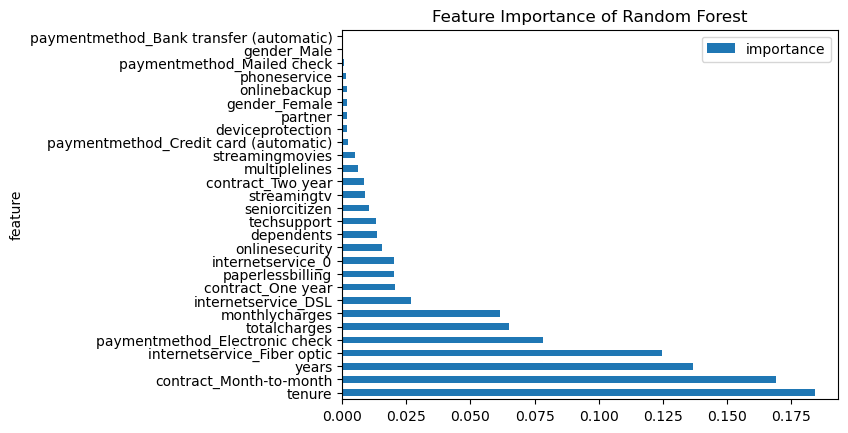

In [39]:
dfc.feature_importances(draw=True)

## KNN

The optimal number of neighbours is 153 with an accuracy of 0.7991483321504613


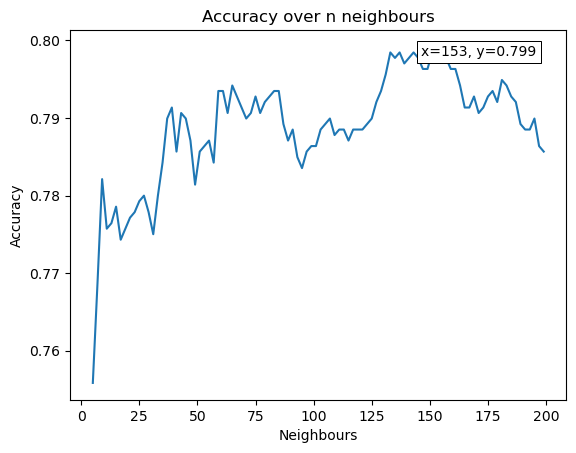

In [40]:
# Compare KNN with different number of neighbours
(k_best_accuracy, k_best_neighbours) = dfc.compare_knn(range(5,201,2), draw=True)
print(f"The optimal number of neighbours is {k_best_neighbours} with an accuracy of {k_best_accuracy[0]}")

# Compare methods

In [41]:

# run with default values:
# _=dfc.compare_methods()

# run with best parameters from the "compare" methods
_ = dfc.compare_methods(d_depth=d_best_depth, n_estimators=rf_best_n_estimators, rf_depth=rf_best_max_depth, neighbours=k_best_neighbours)



Decision tree 0.7842441447835344
Random forest 0.7977288857345636
KNN           0.7991483321504613
Benchmark     0.7388218594748048


# Customers on focus

In [42]:
# Use this model to find out the chance of leaving from the ones who hasn't churned.
dfc.prepare_for_model()
dfc.random_forest()
x = 20
topX = dfc.predict_label(x)
print(f'Top {x} non-churned customers with the highest chance to churn:')
print(topX)

The data contains no nulls, ready for models
Top 20 non-churned customers with the highest chance to churn:
customerID
7439-DKZTW    0.922455
3462-BJQQA    0.895104
9605-WGJVW    0.889678
2262-SLNVK    0.877351
8739-XNIKG    0.857932
6969-MVBAI    0.856808
6630-UJZMY    0.856622
5542-TBBWB    0.848204
9603-OAIHC    0.843414
9840-EFJQB    0.842784
1452-VOQCH    0.833515
1640-PLFMP    0.825485
4132-KALRO    0.825371
4090-KPJIP    0.823046
1197-BVMVG    0.820271
8040-MNRTF    0.816745
5141-ZUVBH    0.810558
2545-EBUPK    0.803092
5032-MIYKT    0.800567
7465-ZZRVX    0.799719
Name: label_probability, dtype: float64
